# Convolutional Neural Networks

Katherine Haynes  
October 28, 2019

This notebook contains the class `NeuralNetwork_Convolutional`, which uses the `torch.nn` module to construct neural networks with initial convolutional layers followed by fully connected layers to learn to classify images.  The network will have some number, possibly zero, layers of convolutional units having the `tanh` activation function.  These are followed by one or more layers with fully connected units with `tanh` activation functions.

A tricky part of building this structure is determining the correct number of inputs to the first fully-connected layer.  This requires knowing the size of the output image generated by the last convolutional layer.  If this layer produces an output image that is $n\times n$ and it has $m$ units, then the concatenation of all image values for all units into one vector to form the input to the fully-connected layer, the resulting vector will be $m \cdot n^2$.

As an example, say our data contains images that are $d\times d$ and we have a neural network with two convolutional layers and one fully connected layer. 

Original input image: 
- $d\times d$ of $c$ channels

First convolutional layer with $u_1$ units having kernels sized $k_1\times k_1$ and strides of $s_1$
- input is $d\times d$ of $c$ channels
- output is $z_1\times z_1$ of $u_1$ channels, where $z_1 = \frac{d - k_1}{s_1} + 1$

Second convolutional layer with $u_2$ units having kernels sized $k_2\times k_2$ and strides of $s_2$
- input is $z_1\times z_1$ of $u_1$ channels
- output is $z_2\times z_2$ of $u_2$ channels, where $z_2 = \frac{z_1 - k_2}{s_2} + 1$


Third convolutional layer is fully-connected, so we must flatten into a vector the output from the previous convolutional layer. Say this layer has $u_3$ units.
- input is $u_2 \, z_2 ^ 2$
- output is $u_3$ values

In [1]:
import numpy as np
import torch
import time
import copy
import sys

class NeuralNetwork_Convolutional():
    
    def __init__(self, n_channels_in_image, image_size,
                 n_units_in_conv_layers, kernels_size_and_stride,
                 n_units_in_fc_hidden_layers,
                 classes, use_gpu=False):

        if not isinstance(n_units_in_conv_layers, list):
            raise Exception('n_units_in_conv_layers must be a list')

        if not isinstance(n_units_in_fc_hidden_layers, list):
            raise Exception('n_units_in_fc_hidden_layers must be a list')
        
        if use_gpu and not torch.cuda.is_available():
            print('\nGPU is not available. Running on CPU.\n')
            use_gpu = False

        self.n_channels_in_image = n_channels_in_image
        self.image_size = image_size 
        self.n_units_in_conv_layers = n_units_in_conv_layers
        self.n_units_in_fc_hidden_layers = n_units_in_fc_hidden_layers
        self.kernels_size_and_stride = kernels_size_and_stride
        self.n_outputs = len(classes)
        self.classes = np.array(classes)
        self.use_gpu = use_gpu
        
        self.n_conv_layers = len(self.n_units_in_conv_layers)
        self.n_fc_hidden_layers = len(self.n_units_in_fc_hidden_layers)

        # Build the net layers
        self.nnet = torch.nn.Sequential()

        # Add convolutional layers
        n_units_previous = self.n_channels_in_image
        output_size_previous = self.image_size
        n_layers = 0
        if self.n_conv_layers > 0:
            for (n_units, kernel) in zip(self.n_units_in_conv_layers,self.kernels_size_and_stride):
                n_units_previous, output_size_previous = self._add_conv2d_tanh(n_layers,
                                        n_units_previous, output_size_previous, n_units, kernel)
                n_layers += 1 # for text label in layer

        self.nnet.add_module('flatten', torch.nn.Flatten())  # prepare for fc layers
        n_inputs = output_size_previous ** 2 * n_units_previous
        if self.n_fc_hidden_layers > 0:
            for n_units in self.n_units_in_fc_hidden_layers:
                n_inputs = self._add_fc_tanh(n_layers, n_inputs, n_units)
                n_layers += 1
        self.nnet.add_module(f'output_{n_layers}', torch.nn.Linear(n_inputs, self.n_outputs))

        # Member variables for standardization
        self.Xmeans = None
        self.Xstds = None

        if self.use_gpu:
            self.nnet.cuda()

        self.n_epochs = 0
        self.error_trace = []

    def _add_conv2d_tanh(self, n_layers, n_units_previous, output_size_previous,
                   n_units, kernel_size_and_stride):
        kernel_size, kernel_stride = kernel_size_and_stride
        self.nnet.add_module(f'conv_{n_layers}', torch.nn.Conv2d(n_units_previous, n_units,
                                                                 kernel_size, kernel_stride))
        self.nnet.add_module(f'output_{n_layers}', torch.nn.Tanh())
        output_size_previous = (output_size_previous - kernel_size) // kernel_stride + 1
        n_units_previous = n_units                
        return n_units_previous, output_size_previous
    
    def _add_fc_tanh(self, n_layers, n_inputs, n_units):
        self.nnet.add_module(f'linear_{n_layers}', torch.nn.Linear(n_inputs, n_units))
        self.nnet.add_module(f'output_{n_layers}', torch.nn.Tanh())
        n_inputs = n_units
        return n_inputs

    def __repr__(self):
        str = f'''{type(self).__name__}(
                            n_channels_in_image={self.n_channels_in_image},
                            image_size={self.image_size},
                            n_units_in_conv_layers={self.n_units_in_conv_layers},
                            kernels_size_and_stride={self.kernels_size_and_stride},
                            n_units_in_fc_hidden_layers={self.n_units_in_fc_hidden_layers},
                            classes={self.classes},
                            use_gpu={self.use_gpu})'''

        str += self.nnet
        if self.n_epochs > 0:
            str += f'\n   Network was trained for {self.n_epochs} epochs that took {self.training_time:.4f} seconds.'
            str += f'\n   Final objective value is {self.error_trace[-1]:.3f}'
        else:
            str += '  Network is not trained.'
        return str
        
    def _standardizeX(self, X):
        result = (X - self.Xmeans) / self.XstdsFixed
        result[:, self.Xconstant] = 0.0
        return result

    def _unstandardizeX(self, Xs):
        return self.Xstds * Xs + self.Xmeans

    def _setup_standardize(self, X, T):
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xconstant = self.Xstds == 0
            self.XstdsFixed = copy.copy(self.Xstds)
            self.XstdsFixed[self.Xconstant] = 1

    def train(self, X, T, n_epochs, learning_rate=0.01):

        start_time = time.time()
        
        self.learning_rate = learning_rate

        if T.ndim == 1:
            T = T.reshape((-1, 1))

        _, T = np.where(T == self.classes)  # convert to labels from 0

        self._setup_standardize(X, T)
        X = self._standardizeX(X)

        X = torch.tensor(X)
        T = torch.tensor(T.reshape(-1))
        if self.use_gpu:
            X = X.cuda()
            T = T.cuda()

        self.loss_F = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.nnet.parameters(), lr=self.learning_rate)
        
        if (n_epochs < 101):
            modPrint = 5
        else:
            modPrint = 50
            
        for epoch in range(n_epochs):
            optimizer.zero_grad()
            Y = self.nnet(X)
            error = self.loss_F(Y,T)
            self.error_trace.append(error.item())

            self.n_epoch = epoch + 1
            if (self.n_epoch) % modPrint == 0:
                print(f'Epoch {self.n_epoch} error {error:.5f}')
                
            error.backward()
            optimizer.step()
         
                    
        stop_time = time.time()
        self.training_time = stop_time - start_time

        Y = self.nnet(X)
        if self.use_gpu:
            Y = Y.cpu()
            T = T.cpu()
            
        Yout = Y.detach().numpy()
        Yclasses = self.classes[Yout.argmax(axis=1)].reshape((-1,1))
        Tout = T.detach().numpy()
        Tclasses = self.classes[Tout].reshape((-1,1))
        
        nCorrect = np.sum(Tclasses == Yclasses)
        nTotal = Tclasses.shape[0]
        pCorrect = nCorrect/nTotal*100.
        print(f'{nCorrect} out of {nTotal} samples correct ({pCorrect}).')

    def get_error_trace(self):
        return self.error_trace
    
    def _softmax(self, Y):
        mx = Y.max()
        expY = np.exp(Y - mx)
        denom = expY.sum(axis=1).reshape((-1, 1)) + sys.float_info.epsilon
        return expY / denom
    
    def use(self, X):
        self.nnet.eval()  # turn off gradients and other aspects of training
        X = self._standardizeX(X)
        X = torch.tensor(X)
        if self.use_gpu:
            X = X.cuda()

        Y = self.nnet(X)

        if self.use_gpu:
            Y = Y.cpu()
        Y = Y.detach().numpy()
        Yclasses = self.classes[Y.argmax(axis=1)].reshape((-1, 1))

        return Yclasses, self._softmax(Y)

Here are two functions to visualize the output from the convolutional layer.  The function `show_layer_output` shows what the convolutional layer produces, and the function `show_layer_weights` shows the weight matrices of each unit that produces the output images.

In [2]:
import matplotlib.pyplot as plt

def show_layer_output(nnet, X_sample, layer):
    outputs = []
    reg = nnet.nnet[layer * 2].register_forward_hook(
        lambda self, i, o: outputs.append(o))
    nnet.use(X_sample)
    reg.remove()
    output = outputs[0]

    n_units = output.shape[1]
    nplots = int(np.sqrt(n_units)) + 1
    for unit in range(n_units):
        plt.subplot(nplots, nplots, unit+1)
        plt.imshow(output[0, unit, :, :].detach(),cmap='binary')
        plt.axis('off')
    return output

def show_layer_weights(nnet, layer):
    W = nnet.nnet[layer*2].weight.detach()
    n_units = W.shape[0]
    nplots = int(np.sqrt(n_units)) + 1
    for unit in range(n_units):
        plt.subplot(nplots, nplots, unit + 1)
        plt.imshow(W[unit, 0, :, :], cmap='binary')
        plt.axis('off')
    return W

# MNIST Digits

Investigate the classification of [MNIST digits](http://deeplearning.net/tutorial/gettingstarted.html).  

This notebook is submitted stand-alone without the data and assumes when running the necessary data are provided.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pickle, gzip

# Load the dataset
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

In [5]:
# Setup training data
Xtrain = train_set[0].reshape(50000,1,28,28)
Ttrain = train_set[1].reshape(50000,1)

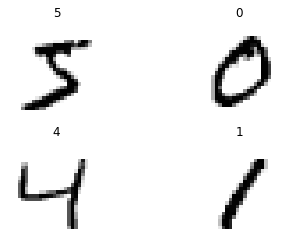

In [6]:
# Plot some sample training images
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(Xtrain[i,0,:,:], cmap='binary')
    plt.title(Ttrain[i,0])
    plt.axis('off');

In [7]:
# Setup testing data
Xtest = test_set[0].reshape(10000,1,28,28)
Ttest = test_set[1].reshape(10000,1)

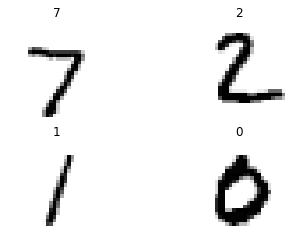

In [8]:
# Plot some sample testing images
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(Xtest[i,0,:,:], cmap='binary')
    plt.title(Ttest[i,0])
    plt.axis('off');

With the data setup, we can now train and test the convolutional neural network.

In [9]:
# Set the desired neural network information
testIters = 200
testConvUnits = [3, 4]
testKSS = [[2, 1], [4,2]]
testFCUnits = [10, 10]
testLR = 0.1
testGPU = False
classes = [0,1,2,3,4,5,6,7,8,9]

In [10]:
# Run the tests
nnet = NeuralNetwork_Convolutional(n_channels_in_image=1, image_size=28,
        n_units_in_conv_layers=testConvUnits, kernels_size_and_stride=testKSS,
        n_units_in_fc_hidden_layers=testFCUnits, classes=classes,use_gpu=testGPU)
nnet.train(Xtrain, Ttrain, testIters, learning_rate=testLR)

Epoch 50 error 1.42641
Epoch 100 error 0.69731
Epoch 150 error 0.48364
Epoch 200 error 0.42062
45226 out of 50000 samples correct (90.452).


In [11]:
# Use the network on the test data
Yclasses, Y = nnet.use(Xtest)
nCorrect = np.sum(Ttest == Yclasses)
nTotal = Ttest.shape[0]
pCorrect = nCorrect/nTotal*100.
print(f'{nCorrect} out of {nTotal} test samples correctly classified ({pCorrect}%).')
print(f'Training took {nnet.training_time:.3f} seconds.')

8894 out of 10000 test samples correctly classified (88.94%).
Training took 1306.639 seconds.


## Discussion

I tried using one convolutional layer with 3 units, a kernal size of 2, a kernal stride of 1, 10 units in one full hidden layer, a learning rate of 0.1, and 100 iterations.  This setup produced an accuracy of 89.84% (90.48%) on the test (training) data.

Next I tried using two convolutional layers and two full hidden layers.  The first convolutional layer had kernal size and stride of 2 and 1, respectively, and the second convolutional layer had kernal size and stride of 4 and 2.  Both full hidden layers had 10 units, and I ran 200 iterations.  This setup produced an accuracy of 94.1% (95.82%) on the test (training) data on my Macbook Pro, and it took 1210 seconds.  I then tried this on Google Colab with a GPU.  It didn't do quite as well, with an accuracy of 90.9% (92.0%) on the test (training) data; however it only took 103 seconds!

Since I had access to a GPU, I then expanded the network to use 3 convolutional layers.  The first had 3 units with kernal size/stride of 2,1; the second had 4 units with kernal size/stride of 4,2; and the third had 3 units with kernal size/stride of 5,1.  I also used 3 hidden layers, all with 10 units.  For this setup, I used a learning rate of 0.1 and 300 iterations.  It completed training in 193 seconds with 96% accuracy.  On the test set, it performed with a 94.3% accuracy.

In trying to make the network more complicated until performance suffered, I tried four convolutional layers with 3, 4, 6, 3 units; sizes of 2, 4, 5, 2; and strides of 1, 2, 3, 1.  I also used three hidden layers with units of 10, 40, 10.  On a GPU, this took 300 seconds.  This finally performed worse, with only an 84% training accuracy and 82% test accuracy.

I did a little more playing around, and the best network I found had an accuracy of 95.8% on the test data.  This was after 500 iterations using 3 convolutional layers and 2 hidden layers.  The three convolutional layers had 3,4,6 units; 2,4,5 sizes; and 1,2,3 strides.  The hidden layers both had 10 units and the learning rate was 0.1.  This took 277 seconds.

## Results

### Error Trace

Text(0, 0.5, 'MSE')

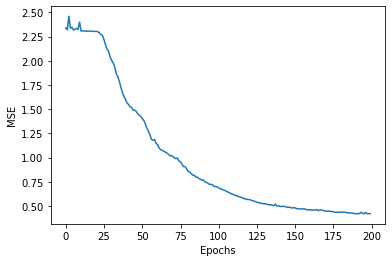

In [12]:
# Show the resulting error trace
plt.plot(nnet.get_error_trace())
plt.xlabel('Epochs')
plt.ylabel('MSE')

With this setup, the error seemed to stabilize after ~150 epochs.  You can tell it uses Adam from the jumps in error.

### Weights

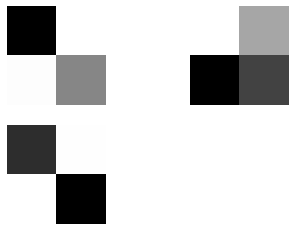

In [13]:
# Show the first layer weights
show_layer_weights(nnet, 0);

In [14]:
# Show the second layer weights
show_layer_weights(nnet, 1);

### Sample Mis-Classified Test Case

We can investigate the output on an incorrect classifications case.  For example, the network predicts a 2 when it should be a 8.  Upon investigation, this could be because half of the 8 does look like a 2, likely making it have many features in common with 2.

Predicted: [8]  Actual: [9]


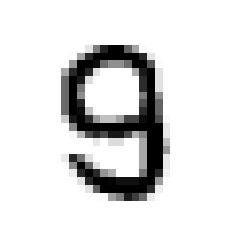

In [15]:
# Show a sample mis-classified test case
badref, badval = np.where(Yclasses != Ttest)
tref = badref[22]
Xsample = Xtest[tref:tref+1, :, :, :]
plt.imshow(Xsample[0, 0, :, :], cmap='binary')
plt.axis('off')
print(f'Predicted: {Yclasses[tref]}  Actual: {Ttest[tref]}')

In [16]:
# Show the first layer output
output = show_layer_output(nnet, Xsample, 0)

The output from the first layer is much cleaner appearing (above) where there are less units and a single stride.  The output from the second layer is quite messy, which could be due to a more complicated weight pattern and difficulties matching the pattern resulting in the incorrect classification. 

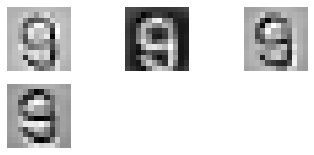

In [17]:
# Show the second layer output
output = show_layer_output(nnet, Xsample, 1)

### Sample Correctly Classified Case

Now we can investigate the output on a correctly classified case.  Choosing one, in this case the network correctly predicts a 9.  Scrolling through the correctly predicted numbers, they do seem to have pretty disctintive features the network is able to pick up on.  Both convolutional layers appear to be pretty cohesive compared to the mis-classified case.

Predicted: [4]  Actual: [4]


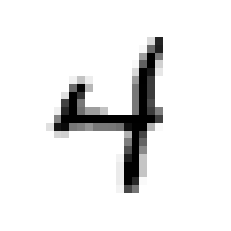

In [18]:
# Show a sample correctly classified test case
badref, badval = np.where(Yclasses == Ttest)
tref = badref[3210]
Xsample = Xtest[tref:tref+1, :, :, :]
plt.imshow(Xsample[0, 0, :, :], cmap='binary')
plt.axis('off')
print(f'Predicted: {Yclasses[tref]}  Actual: {Ttest[tref]}')

In [19]:
# Show the first layer output
output = show_layer_output(nnet, Xsample, 0)

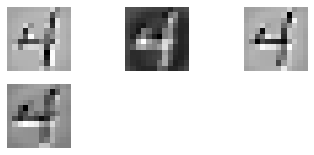

In [20]:
# Show the second layer output
output = show_layer_output(nnet, Xsample, 1)

While the images help see what is going on, for future work I'd want to do more investigation into the test cases that failed to see if any patterns emerged.  Two things jump out at me: 1) which numbers are incorrectly predicted, and 2) which numbers does the network use instead of the actual values.  Perhaps by analyzing these improvements could be made to the network.